# Desafio 5

Como Cientista de Datos te han contratado en una importante empresa de propiedades para analizar las diferentes características de algunas casas que se han vendido en el último
tiempo, y que se encuentran en el dataset house_data.xlsx. Esta base de datos contiene diversas características de estas propiedades y su precio. Específicamente, se te solicita:
1. Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que
puedan afectar la calidad del modelo, si los hay. 
2. Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto
debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas
3. Aplicar técnicas de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. Luego de ello,
divide el conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada.
4. Implementar modelos de regresión lineal con regularización, como Ridge, Lasso o Elastic Net y ajuste los hiper parámetros mostrando como se mueve los
hiperparametros y el ajuste. Además, debes construir modelos de árboles de regresión para capturar relaciones no lineales y complejas entre las variables
predictoras y el precio de las casas.
5. Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²), para medir el
rendimiento del modelo y concluir sobre ellos.

In [1]:
pip install uszipcode sqlalchemy-mate==2.0.0.0 python-Levenshtein plotly

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import missingno as msngo
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import plotly.express as px

pd.options.display.max_columns = None
df = pd.read_excel('Data/house_data.xlsx')
df.head()

id             date   price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900         3       1.00         1180   
1  6414100192  20141209T000000  538000         3       2.25         2570   
2  5631500400  20150225T000000  180000         2       1.00          770   
3  2487200875  20141209T000000  604000         4       3.00         1960   
4  1954400510  20150218T000000  510000         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0           0     0          3      7        1180   
1      7242     2.0           0     0          3      7        2170   
2     10000     1.0           0     0          3      6         770   
3      5000     1.0           0     0          5      7        1050   
4      8080     1.0           0     0          3      8        1680   

   sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0              0      1955             0    98178  47.5112 -122.257   
1            400      1951          1991    98125  47.7210 -122.319   
2              0      1933             0    98028  47.7379 -122.233   
3            910      1965             0    98136  47.5208 -122.393   
4              0      1987             0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

## Analisis de datos y limpieza

Analizar la calidad de datos, para lo que debes cargarlos y realizar un proceso exhaustivo de limpieza para eliminar valores faltantes, duplicados y atípicos que puedan afectar la calidad del modelo, si los hay.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [4]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

Ya que sqft_above es igual a la resta de sqft living - basement se eliminará de la operacion

In [5]:
df.sqft_living-df.sqft_basement == df.sqft_above

0        True
1        True
2        True
3        True
4        True
         ... 
21608    True
21609    True
21610    True
21611    True
21612    True
Length: 21613, dtype: bool

<Axes: >

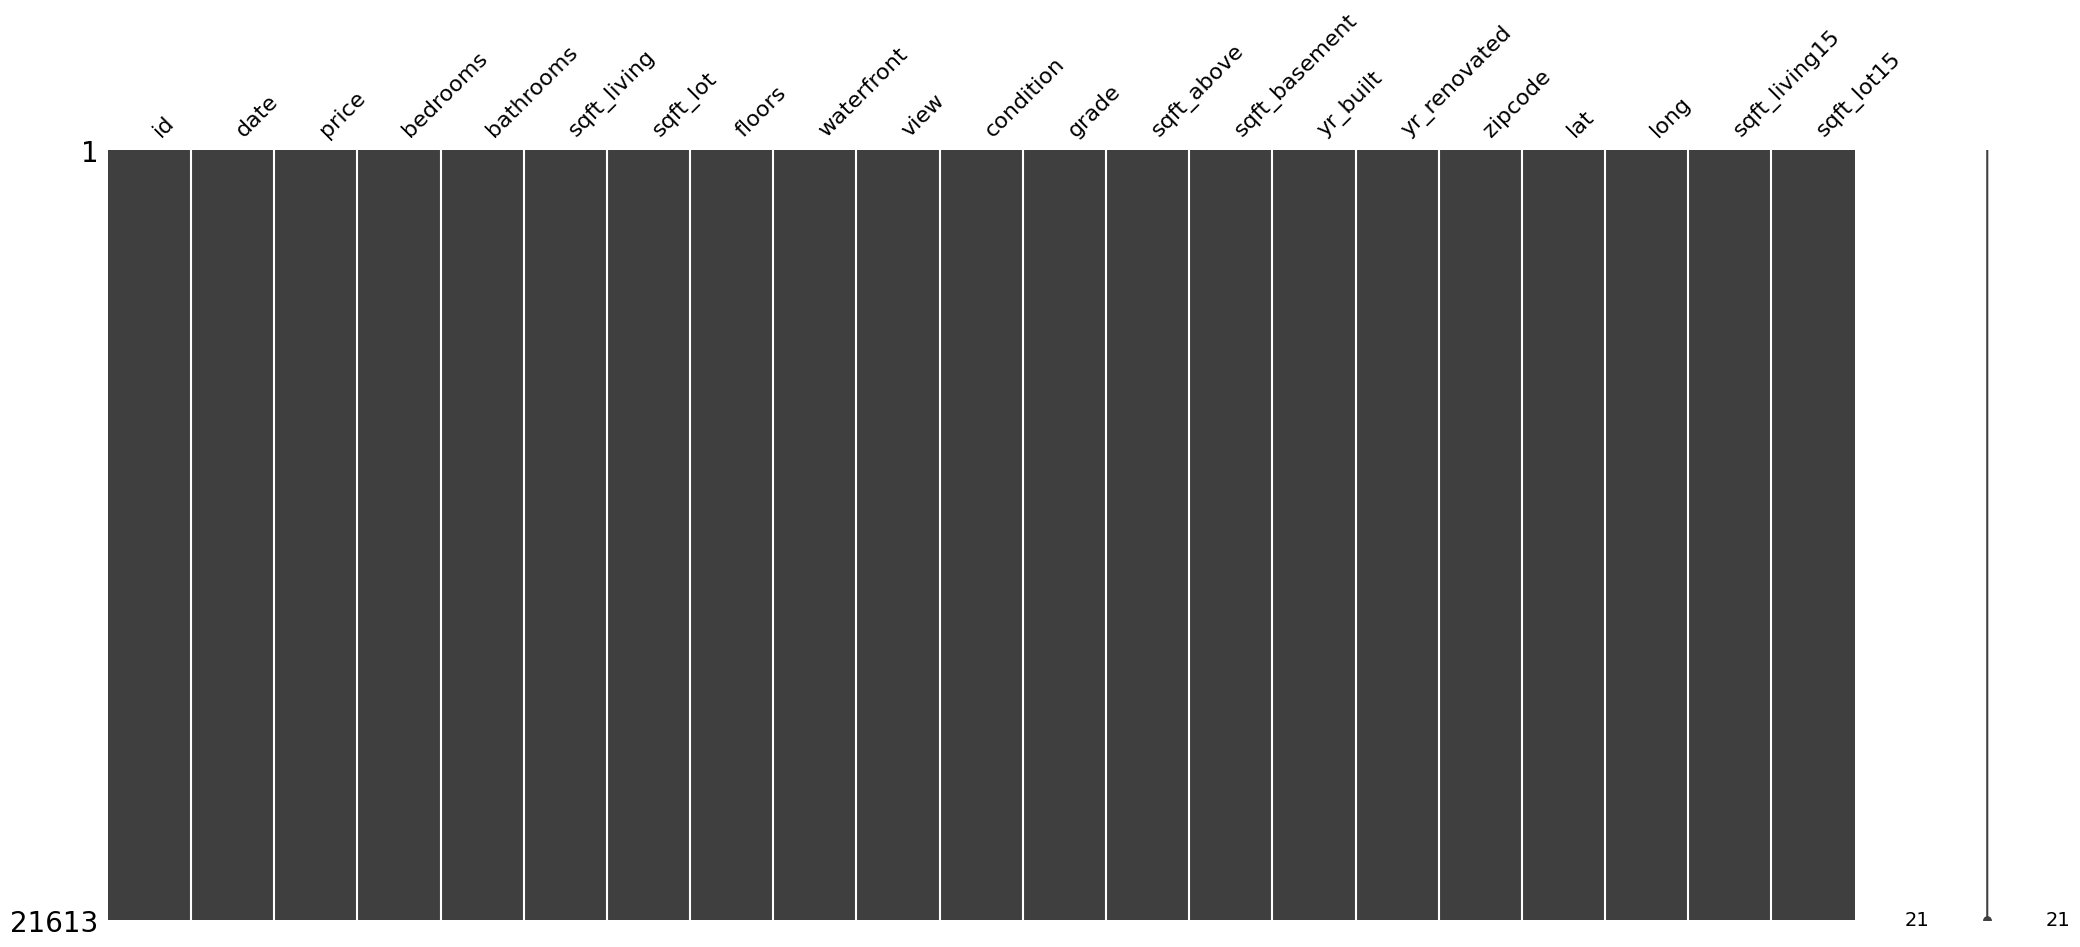

In [6]:
msngo.matrix(df)

No se observan datos faltantes en el dataset

Para el tema de zipcode y latitud y longitud, lo cambiaremos por una variable categorica de las ciudades y la haremos dummy

In [7]:
from uszipcode import SearchEngine, SimpleZipcode
search = SearchEngine()

def zco(x):
    city = search.by_zipcode(x).major_city
    return city if city else 'None'

df['city'] = df['zipcode'].apply(zco)
df.drop(columns=['id', 'zipcode', 'lat', 'long', 'sqft_above', 'date'], inplace=True)

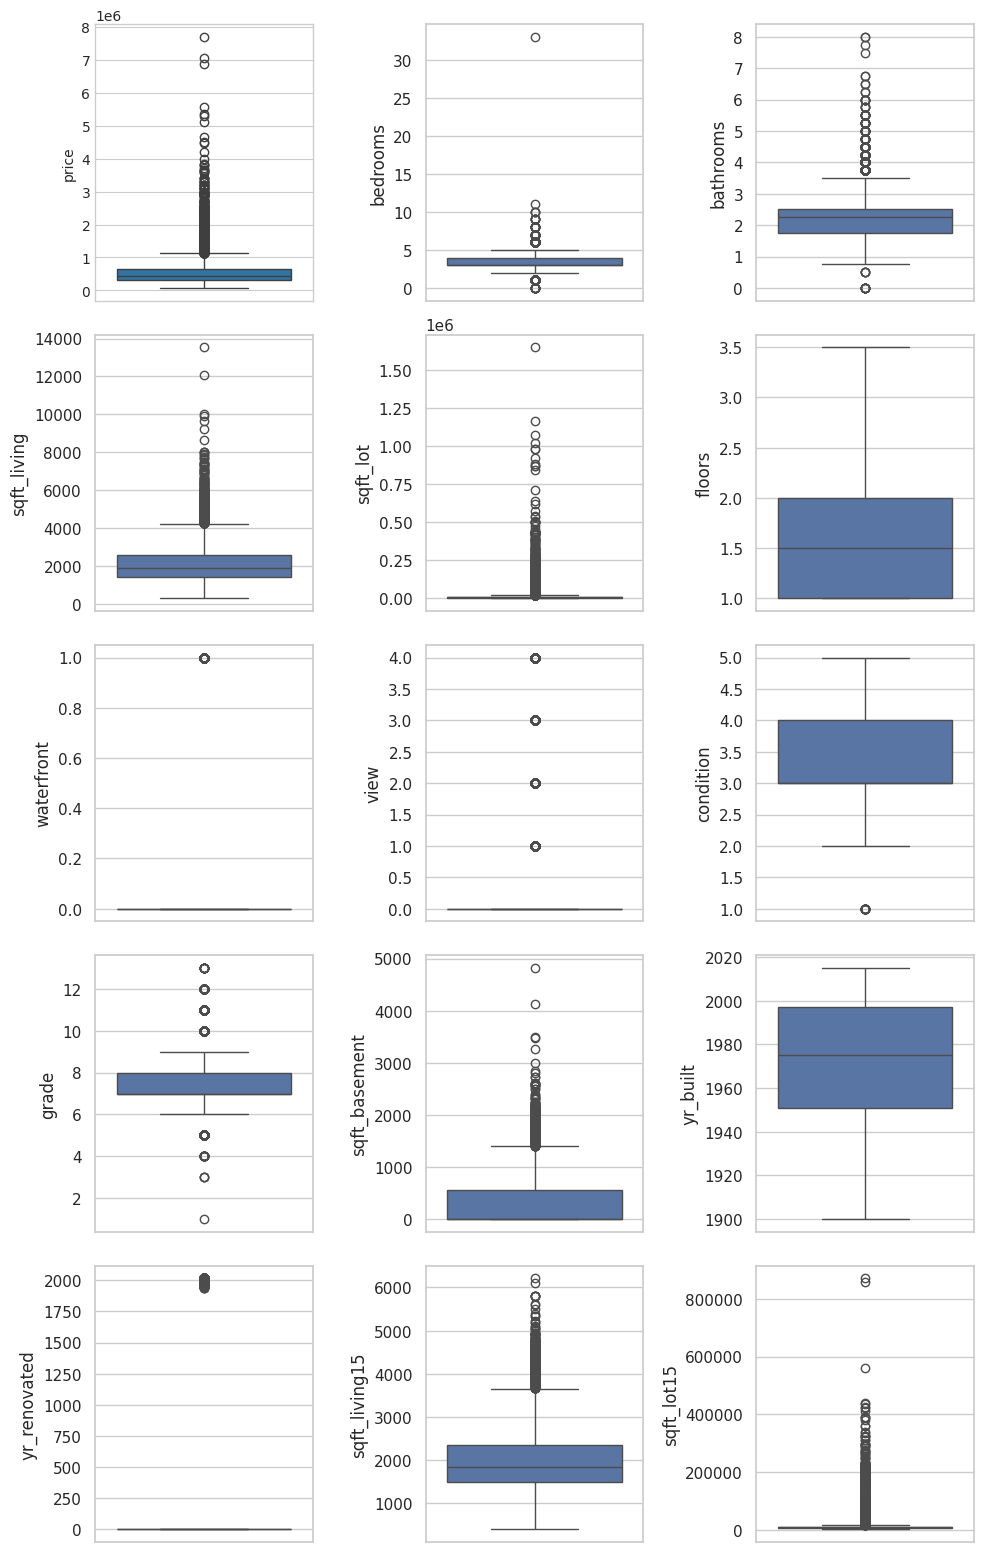

In [8]:
numeric_columns = df.select_dtypes(include=np.number).columns
plt.rcParams["figure.figsize"] = (10, 25)
plt.style.use('seaborn-v0_8-whitegrid')
for column in numeric_columns:
    plt.subplot(8,3, list(numeric_columns).index(column)+1)
    sns.set(style='whitegrid')
    sns.boxplot(y=column, data=df)
    plt.ylabel(column)
plt.tight_layout()

Se observan una gran cantidad de outliers en la muestra de datos, en caso de bedroom por ejemplo, se procede a eliminar outliers por IQR

In [9]:
def drop_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   not_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return not_outliers
df['bedrooms'] = drop_outliers_IQR(df.bedrooms)
df = df.dropna()

## Analisis descriptivo de datos

Realizar un análisis descriptivo de las variables para entender la distribución de los datos y detectar posibles relaciones entre las características y los precios. En esto debes incluir un análisis de correlaciones entre las variables principalmente con el precio de las casas

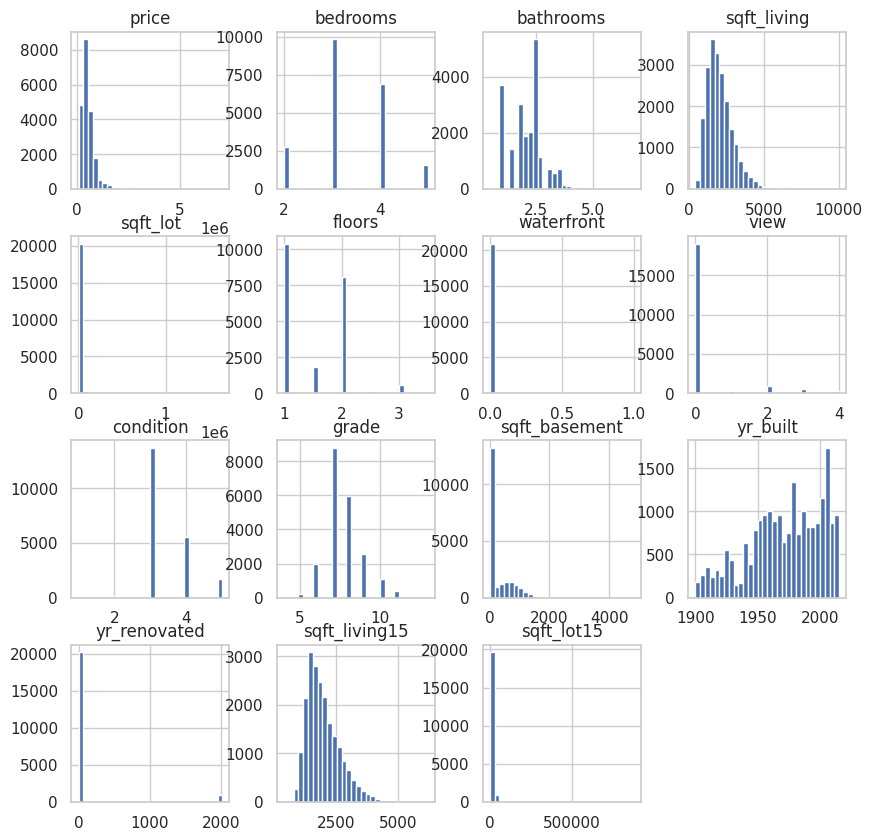

In [10]:
plt.rcParams["figure.figsize"] = (10, 10)
df.hist(bins=30)
plt.show()

<Axes: >

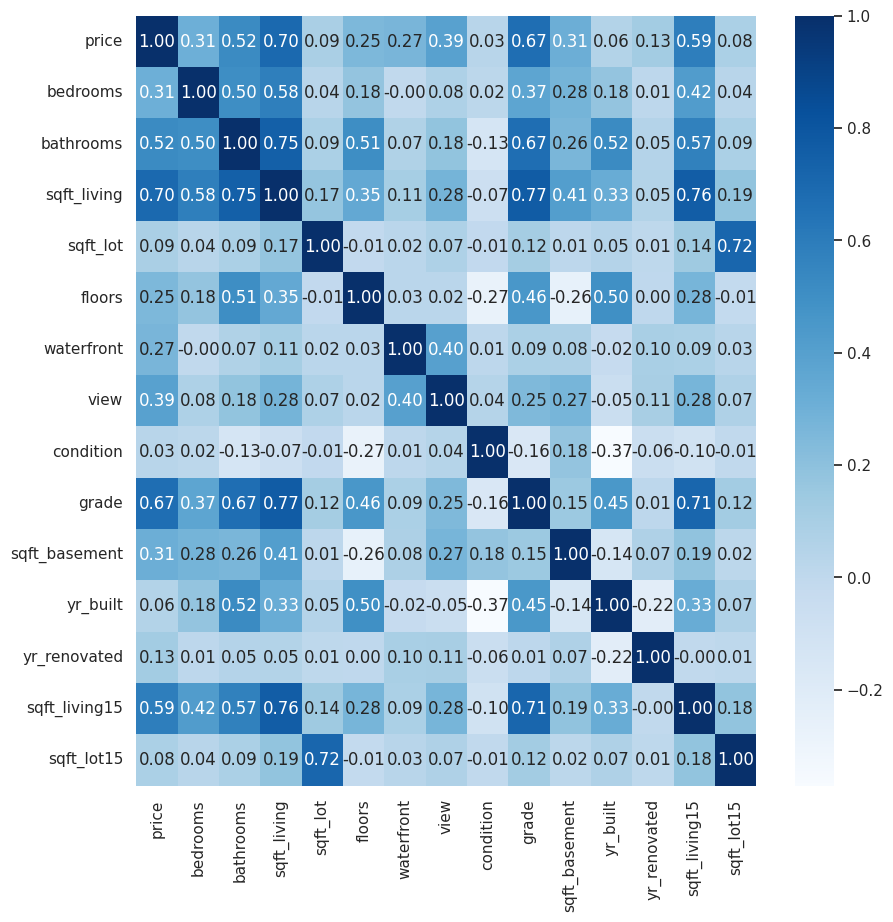

In [11]:
sns.heatmap(df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
        'floors', 'waterfront', 'view', 'condition', 'grade', 
        'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15', 'sqft_lot15']].corr(), annot=True, fmt='.2f',  cmap='Blues' )

Se observa la correlacion entre sqft_living y sqft_living15 por lo que la segunda procedera a eliminarse

Se observa la correlacion entre sqft_lot y sqft_lot15 por lo que la segunda igual se eliminará

Las features que mas afectan el precio de las casas segun la correlacion encontrada son:
1. sqft_living
2. grade
3. bathrooms
4. bedrooms

In [12]:
df.drop(columns=['sqft_living15', 'sqft_lot15'], inplace=True)

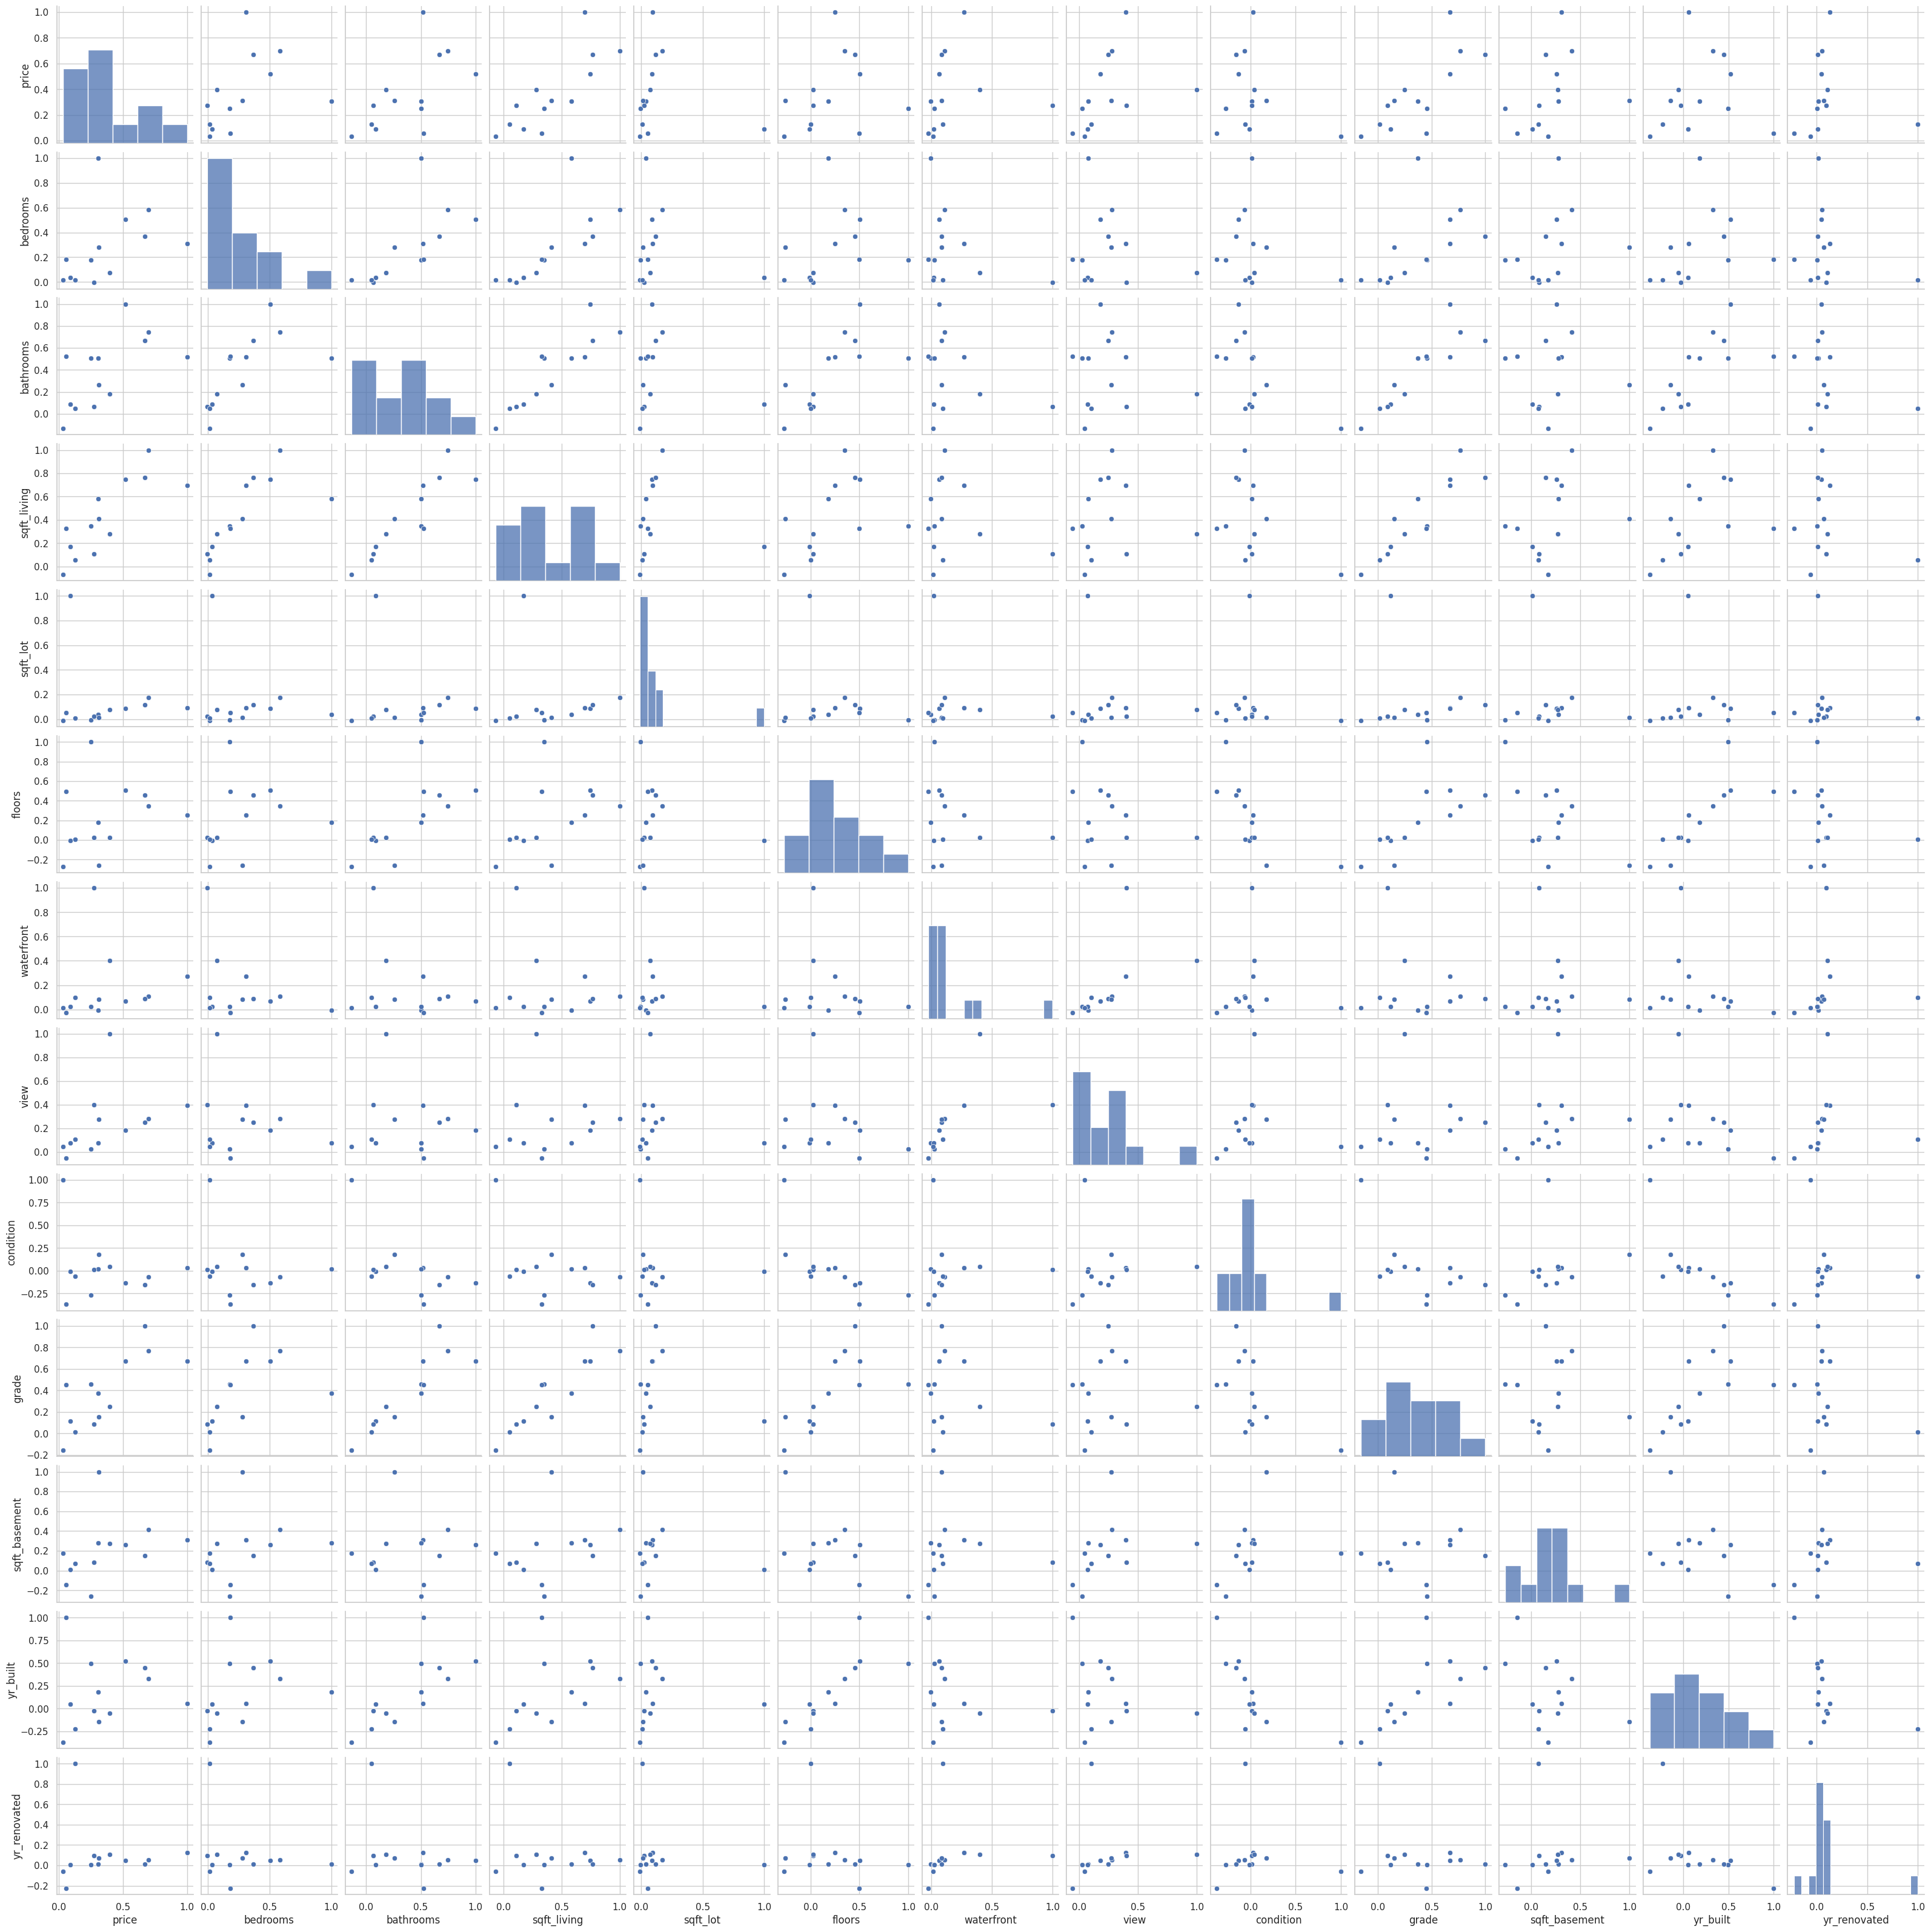

In [13]:
plt.rcParams["figure.figsize"] = (10, 10)
sns.pairplot(df[[
    'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot','floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 
    'yr_built', 'yr_renovated']].corr())

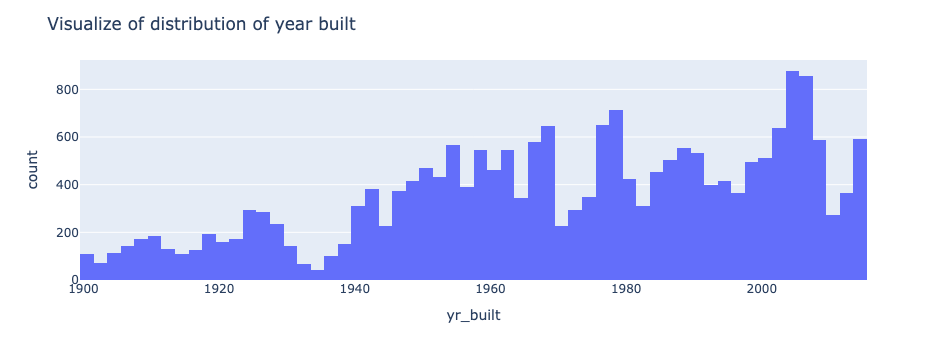

In [14]:
fig=px.histogram(x=df['yr_built'])
fig.update_layout(xaxis_title='yr_built',
                  title='Visualize of distribution of year built')
fig.show()

## Transformaciones de datos

Aplicar técnicas de transformación de datos, como normalización o estandarización, para asegurar que las variables estén en una escala comparable. Luego de ello, divide el conjunto de datos en conjuntos de entrenamiento y prueba de manera aleatoria o estratificada.

Una anotacion encontrada es la columna yr_renovated que tiene el año de renovacion si fue renovada, si no lo fue tiene 0, esta columna asi tal cual producira problemas en el modelo por lo que dejaremos solo una flag si fue renovada

In [15]:
df['renovated'] = df.yr_renovated.apply(lambda x: True if x > 0 else False)
df.drop(columns=['yr_renovated'], inplace=True)

In [16]:
cities = pd.get_dummies(df['city'], prefix='city')
df = df.join(cities).drop(columns=['city'])

In [ ]:
from sklearn.preprocessing import StandardScaler

In [17]:
x = df.drop(columns=['price'],axis=1)
y = df['price']

scaler = StandardScaler()
x = scaler.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

## Regresion lineal y Arbol de Regresiones

Implementar modelos de regresión lineal con regularización, como Ridge, Lasso o Elastic Net y ajuste los hiper parámetros mostrando como se mueve los hiperparametros y el ajuste. Además, debes construir modelos de árboles de regresión para capturar relaciones no lineales y complejas entre las variables predictoras y el precio de las casas.

In [18]:
from sklearn.linear_model import Ridge

In [19]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5, 10],
    'solver': ['auto', 'svd', 'cholesky', 'sparse_cg', 'sag', 'saga'],
}
ridge_model = Ridge()

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=10, verbose=1)
grid_search_ridge.fit(X_train, y_train)
# Obtener los resultados de la búsqueda
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_
print("Mejores hiperparámetros:", best_params_ridge)
print("Precisión con los mejores hiperparámetros:", best_score_ridge)
grid_search_ridge.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Mejores hiperparámetros: {'alpha': 10, 'solver': 'sparse_cg'}
Precisión con los mejores hiperparámetros: 0.7401672228452848


Ridge(alpha=10, solver='sparse_cg')

In [20]:
from sklearn.tree import DecisionTreeRegressor

In [21]:
param_grid = {
    'random_state': [0],
    'max_depth': [5, 10, 30, 100, 200],
    'criterion': ["squared_error", "absolute_error", "poisson"],
    'min_samples_split': [15, 20]
}
dtr_model = DecisionTreeRegressor(random_state=0)

# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search_dtr = GridSearchCV(dtr_model, param_grid, cv=10, verbose=1)
grid_search_dtr.fit(X_train, y_train)
# Obtener los resultados de la búsqueda
best_params_dtr = grid_search_dtr.best_params_
best_score_dtr = grid_search_dtr.best_score_
print("Mejores hiperparámetros:", best_params_dtr)
print("Precisión con los mejores hiperparámetros:", best_score_dtr)
grid_search_dtr.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 100, 'min_samples_split': 20, 'random_state': 0}
Precisión con los mejores hiperparámetros: 0.7377674705884314


DecisionTreeRegressor(max_depth=100, min_samples_split=20, random_state=0)

In [22]:
model_dtr = grid_search_dtr.best_estimator_
model_rdge = grid_search_ridge.best_estimator_

## Evaluacion

Utilizar métricas de evaluación de regresión, como el Error Cuadrático Medio (MSE), el Error Absoluto Medio (MAE) y el Coeficiente de Determinación (R²), para medir el rendimiento del modelo y concluir sobre ellos.

### LR Ridge

In [23]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, model_rdge.predict(X_test))
r2 = r2_score(y_test, model_rdge.predict(X_test))
mae = mean_absolute_error(y_test, model_rdge.predict(X_test))
mse, r2, mae

(32991172377.07205, 0.7318032924004516, 116447.60262283063)

In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
mse = mean_squared_error(y_test, model_dtr.predict(X_test))
r2 = r2_score(y_test, model_dtr.predict(X_test))
mae = mean_absolute_error(y_test, model_dtr.predict(X_test))
mse, r2, mae

(35293297861.31881, 0.7130885141470698, 108239.0494110355)